# **Predicting Airline Passenger Satisfaction**

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# **Data Loading**

In [74]:
Airline_train_data = pd.read_csv('/content/train.csv')
Airline_test_data = pd.read_csv('/content/test.csv')

In [75]:
print(f'The Shape of Airline train data is: {Airline_train_data.shape}')

The Shape of Airline train data is: (103904, 25)


In [76]:
Airline_train_data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [77]:
print("Training Data Shape:", Airline_train_data.shape)
print("Test Data Shape:", Airline_test_data.shape)
print("\nTraining Data Info:")
print(Airline_train_data.info())

Training Data Shape: (103904, 25)
Test Data Shape: (25976, 25)

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booki

# **Data Cleaning**

In [78]:
#removing unnecessary columns
Airline_train_data.drop(['Unnamed: 0'], axis=1, inplace=True)
Airline_train_data.drop(['id'], axis=1, inplace=True)
print(Airline_train_data.columns)

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')


In [79]:
#Check for Duplicates
print("Duplicate rows in train:", Airline_train_data.duplicated().sum())
Airline_train_data = Airline_train_data.drop_duplicates()

Duplicate rows in train: 0


In [80]:
#Check for missing Values
print("Missing values in training data:\n", Airline_train_data.isnull().sum())

Missing values in training data:
 Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64


In [81]:
Airline_train_data.fillna(0, inplace=True)

In [82]:
Airline_train_data.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.133392
std,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.649776
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [83]:
#All categorical columns
Airline_train_data.select_dtypes(include=['object']).columns

Index(['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction'], dtype='object')

In [84]:
#Replace NaN with mode for categorical data
Airline_train_data['Gender'] = Airline_train_data['Gender'].fillna(Airline_train_data['Gender'].mode()[0])
Airline_train_data['Customer Type'] = Airline_train_data['Customer Type'].fillna(Airline_train_data['Customer Type'].mode()[0])
Airline_train_data['Type of Travel'] = Airline_train_data['Type of Travel'].fillna(Airline_train_data['Type of Travel'].mode()[0])
Airline_train_data['Class'] = Airline_train_data['Class'].fillna(Airline_train_data['Class'].mode()[0])

In [85]:
# Convert categorical variables to category type (optional but memory-efficient)
categorical_cols = Airline_train_data.select_dtypes(include='object').columns

for col in categorical_cols:
    Airline_train_data[col] = Airline_train_data[col].astype('category')
    Airline_train_data[col] = Airline_train_data[col].astype('category')

In [86]:
print("Cleaned Training Data Shape:", Airline_train_data.shape)
print("Any missing values left:", Airline_train_data.isnull().sum().sum())
print("\nColumn types:\n", Airline_train_data.dtypes)

Cleaned Training Data Shape: (103904, 23)
Any missing values left: 0

Column types:
 Gender                               category
Customer Type                        category
Age                                     int64
Type of Travel                       category
Class                                category
Flight Distance                         int64
Inflight wifi service                   int64
Departure/Arrival time convenient       int64
Ease of Online booking                  int64
Gate location                           int64
Food and drink                          int64
Online boarding                         int64
Seat comfort                            int64
Inflight entertainment                  int64
On-board service                        int64
Leg room service                        int64
Baggage handling                        int64
Checkin service                         int64
Inflight service                        int64
Cleanliness                             i

# **Test Data**

In [87]:
Airline_test_data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [88]:
print("\nTesting Data Info:")
print(Airline_test_data.info())


Testing Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                     

In [89]:
#removing unnecessary columns
Airline_test_data.drop(['Unnamed: 0'], axis=1, inplace=True)
Airline_test_data.drop(['id'], axis=1, inplace=True)

In [90]:
print(Airline_test_data.columns)

Index(['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')


In [91]:
print("Missing values in testing data:\n", Airline_test_data.isnull().sum())

Missing values in testing data:
 Gender                                0
Customer Type                         0
Age                                   0
Type of Travel                        0
Class                                 0
Flight Distance                       0
Inflight wifi service                 0
Departure/Arrival time convenient     0
Ease of Online booking                0
Gate location                         0
Food and drink                        0
Online boarding                       0
Seat comfort                          0
Inflight entertainment                0
On-board service                      0
Leg room service                      0
Baggage handling                      0
Checkin service                       0
Inflight service                      0
Cleanliness                           0
Departure Delay in Minutes            0
Arrival Delay in Minutes             83
satisfaction                          0
dtype: int64


In [92]:
#Handling Missing values
Airline_test_data.fillna(0, inplace=True)

In [93]:
Airline_test_data.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.00000,25976.000000
mean,39.620958,1193.788459,2.724746,3.046812,2.756775,2.977094,3.215353,3.261665,3.449222,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226,14.30609,14.693756
std,15.135685,998.683999,1.335384,1.533371,1.412951,1.282133,1.331506,1.355536,1.320090,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330,37.42316,37.466787
min,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.00000,0.000000
50%,40.000000,849.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.00000,0.000000
75%,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.00000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1128.00000,1115.000000


In [94]:
print("Cleaned Testing Data Shape:", Airline_test_data.shape)
print("Any missing values left:", Airline_test_data.isnull().sum().sum())
print("\nColumn types:\n", Airline_test_data.dtypes)

Cleaned Testing Data Shape: (25976, 23)
Any missing values left: 0

Column types:
 Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay i

# **Data Preprocessing**

In [95]:
le = LabelEncoder()
for col in ['Gender', 'Customer Type', 'Type of Travel', 'Class']:
    Airline_test_data[col] = le.fit_transform(Airline_test_data[col])

In [96]:
# Step 1: Define service-related columns
service_columns = [
    "Inflight wifi service", "Seat comfort", "Food and drink", "Inflight entertainment",
    "On-board service", "Leg room service", "Baggage handling", "Checkin service",
    "Inflight service", "Cleanliness", "Online boarding", "Ease of Online booking",
    "Gate location", "Departure/Arrival time convenient"
]

# Step 2: Calculate the average service rating for each passenger
Airline_train_data["service_avg"] = Airline_train_data[service_columns].mean(axis=1)

# Step 3: Create a new satisfaction_level column
def classify_satisfaction(row):
    if row["satisfaction"] == "satisfied":
        return "satisfied"
    elif row["service_avg"] >= 3.5:
        return "neutral"
    else:
        return "dissatisfied"

Airline_train_data["satisfaction_level"] = Airline_train_data.apply(classify_satisfaction, axis=1)

# Step 4: Check the new satisfaction levels
print(Airline_train_data["satisfaction_level"].value_counts())


satisfaction_level
dissatisfied    47471
satisfied       45025
neutral         11408
Name: count, dtype: int64


# **Exploratory Data Analysis (EDA)**

**Satisfaction Levels**

<ipython-input-97-021b4f6dfd92>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Airline_train_data, x="satisfaction_level", order=["dissatisfied", "neutral", "satisfied"], palette="Set2")


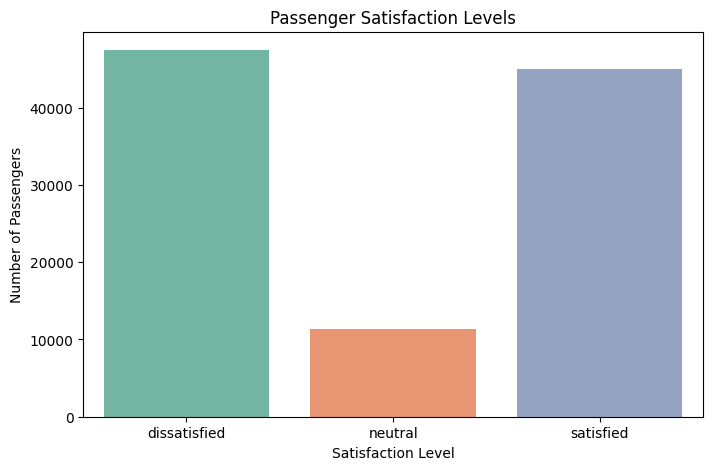

In [97]:
plt.figure(figsize=(8, 5))
sns.countplot(data=Airline_train_data, x="satisfaction_level", order=["dissatisfied", "neutral", "satisfied"], palette="Set2")
plt.title("Passenger Satisfaction Levels")
plt.xlabel("Satisfaction Level")
plt.ylabel("Number of Passengers")
plt.show()

**Countplot showing Satisfaction level by Age Group**

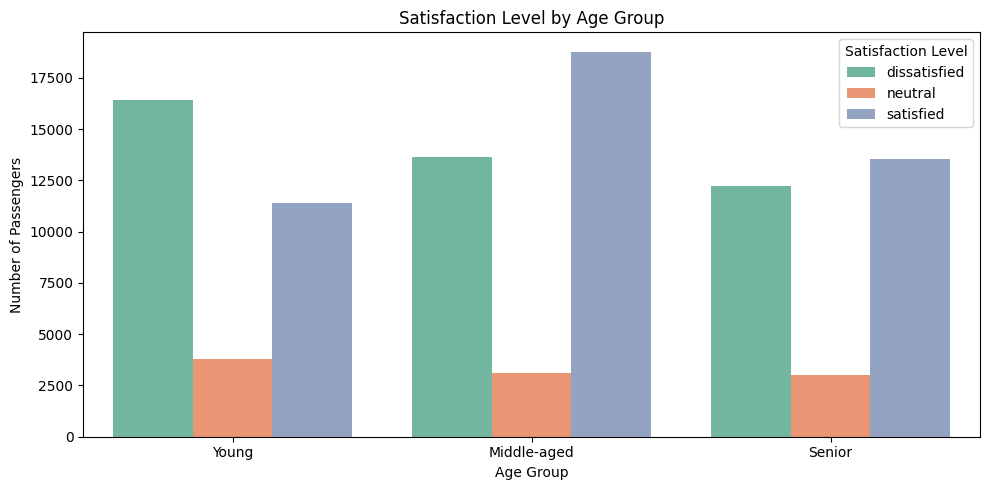

In [98]:
# Create Age Groups: Young (18–34), Middle-aged (35–49), Senior (50+)
bins = [18, 35, 50, 100]
labels = ['Young', 'Middle-aged', 'Senior']
Airline_train_data['Age_Group'] = pd.cut(Airline_train_data['Age'], bins=bins, labels=labels, right=False)

# Plot Age Group vs Satisfaction Level
plt.figure(figsize=(10, 5))
sns.countplot(x='Age_Group',
              hue='satisfaction_level',
              data=Airline_train_data,
              palette='Set2',
              order=labels,
              hue_order=['dissatisfied', 'neutral', 'satisfied'])

plt.title('Satisfaction Level by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Passengers')
plt.legend(title='Satisfaction Level')
plt.tight_layout()
plt.show()


**Mosaic plot: Satisfaction level by Gender and Customer Type**

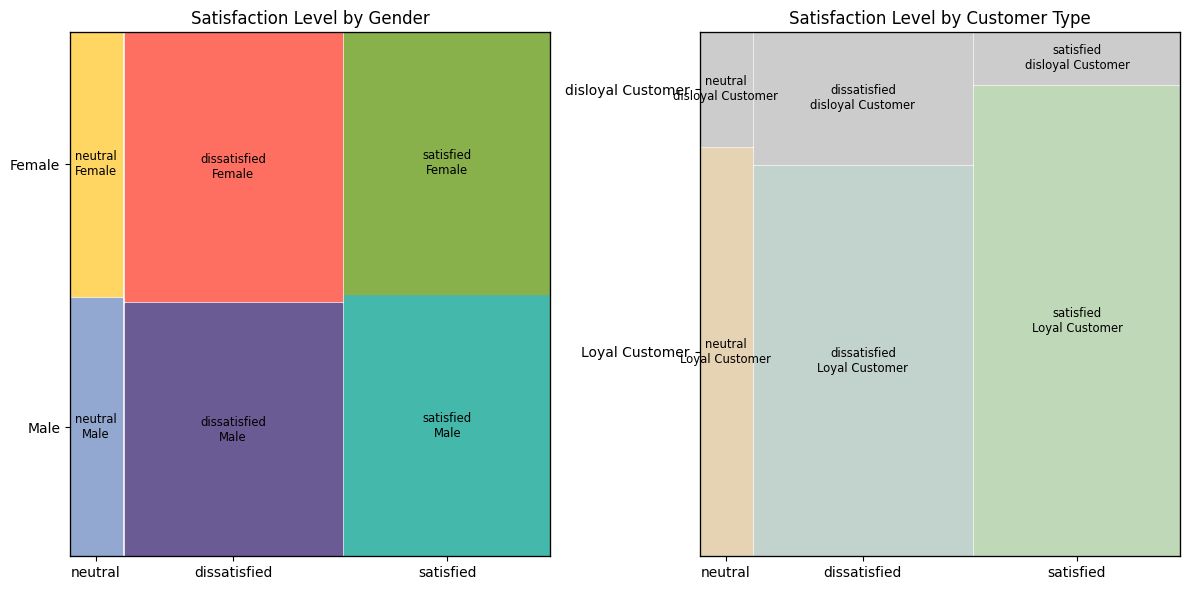

In [99]:
from statsmodels.graphics.mosaicplot import mosaic

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Custom colors for Gender vs Satisfaction Level
custom_colors_gender = {
    ('dissatisfied', 'Female'): '#FF6F61',
    ('dissatisfied', 'Male'): '#6B5B95',
    ('neutral', 'Female'): '#FFD662',
    ('neutral', 'Male'): '#92A8D1',
    ('satisfied', 'Female'): '#88B04B',
    ('satisfied', 'Male'): '#45B8AC'
}

# Mosaic plot: Satisfaction Level vs Gender
mosaic(Airline_train_data, ['satisfaction_level', 'Gender'],
       ax=axes[0],
       properties=lambda key: {'color': custom_colors_gender.get(key, '#CCCCCC')})
axes[0].set_title("Satisfaction Level by Gender")

# Custom colors for Customer Type vs Satisfaction Level
custom_colors_type = {
    ('dissatisfied', 'Loyal Customer'): '#C2D3CD',
    ('dissatisfied', 'Disloyal Customer'): '#A9BCD05',
    ('neutral', 'Loyal Customer'): '#E6D3B3',
    ('neutral', 'Disloyal Customer'): 'D3C0CD',
    ('satisfied', 'Loyal Customer'): '#BFD8B8',
    ('satisfied', 'Disloyal Customer'): '#CED3DC'
}

# Mosaic plot: Satisfaction Level vs Customer Type
mosaic(Airline_train_data, ['satisfaction_level', 'Customer Type'],
       ax=axes[1],
       properties=lambda key: {'color': custom_colors_type.get(key, '#CCCCCC')})
axes[1].set_title("Satisfaction Level by Customer Type")

plt.tight_layout()
plt.show()


**Countplot: Satisfaction level by class and Type of travel**

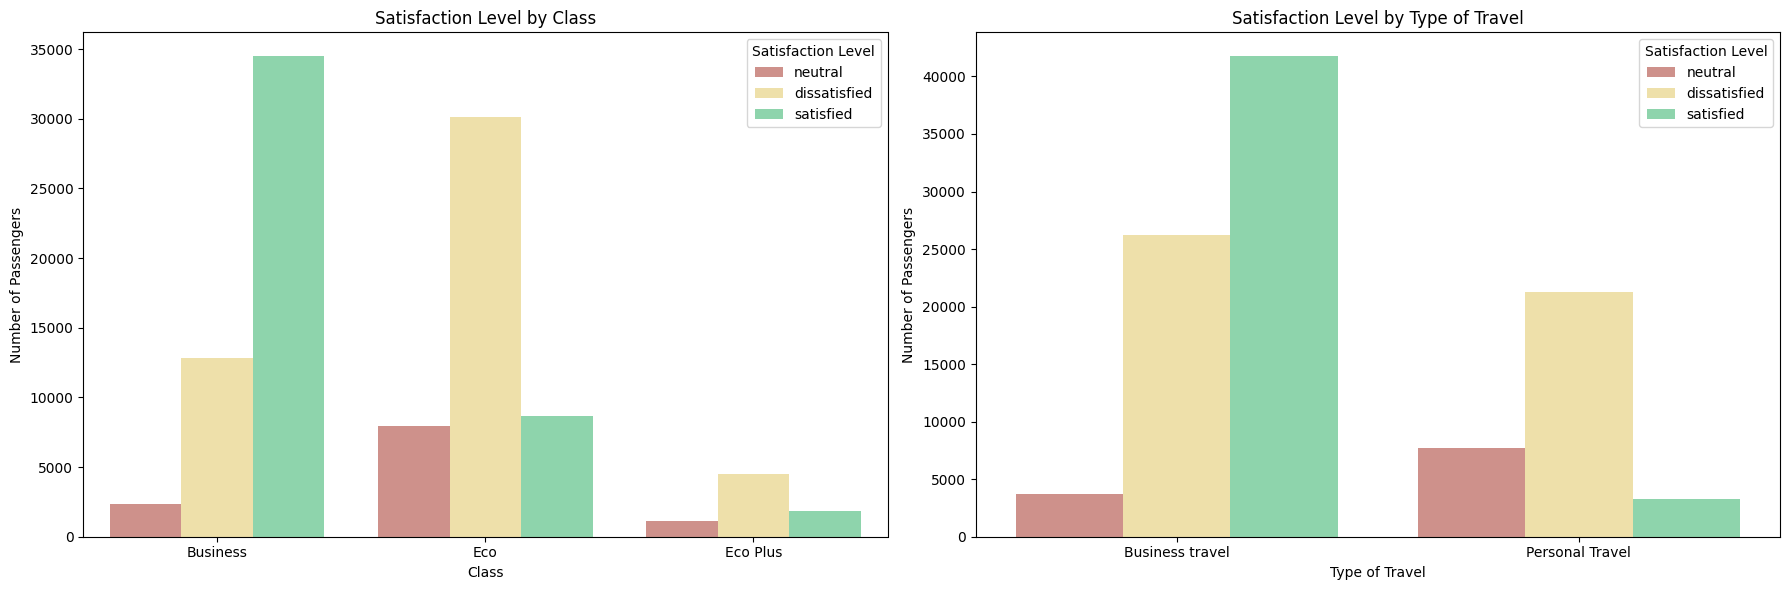

In [100]:
#Countplot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

custom_palette = ['#D98880', '#F9E79F', '#82E0AA']  # Dissatisfied, Neutral, Satisfied

# Plot 1: Class vs Satisfaction Level
sns.countplot(x='Class', hue='satisfaction_level', data=Airline_train_data,
              palette=custom_palette, ax=axes[0])
axes[0].set_title('Satisfaction Level by Class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Passengers')
axes[0].legend(title='Satisfaction Level')

# Plot 2: Type of Travel vs Satisfaction Level
sns.countplot(x='Type of Travel', hue='satisfaction_level', data=Airline_train_data,
              palette=custom_palette, ax=axes[1])
axes[1].set_title('Satisfaction Level by Type of Travel')
axes[1].set_xlabel('Type of Travel')
axes[1].set_ylabel('Number of Passengers')
axes[1].legend(title='Satisfaction Level')

plt.tight_layout()
plt.show()


**Catplot: Departure and Arrival delay by Class and Type of travel**

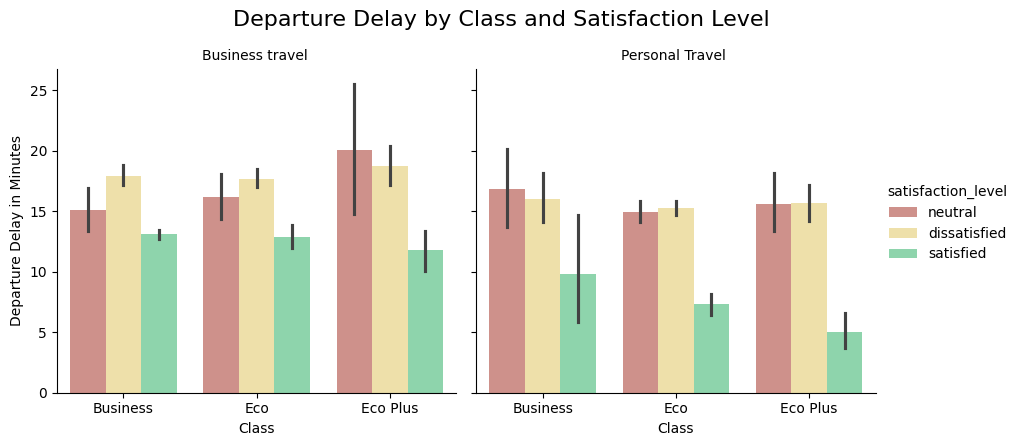

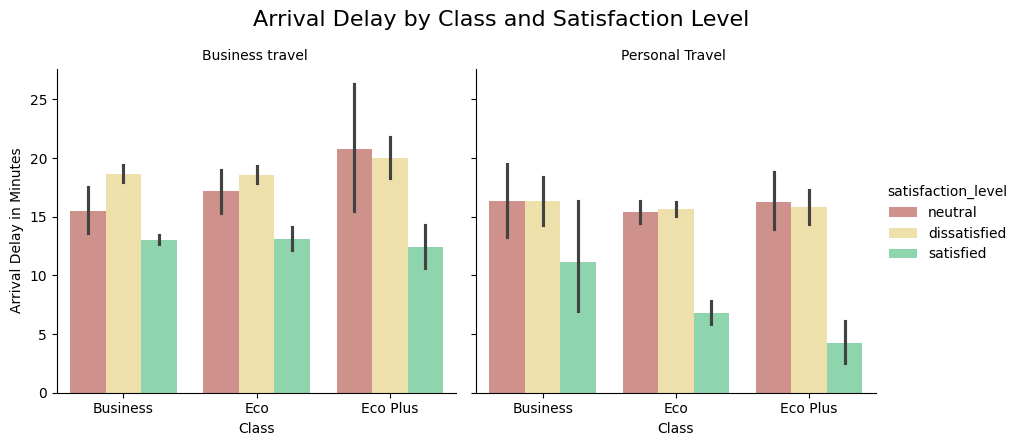

In [101]:
# Departure Delay by Type_of_Travel and Class
g = sns.catplot(
    x="Class",
    y="Departure Delay in Minutes",
    hue="satisfaction_level",
    col="Type of Travel",
    data=Airline_train_data,
    kind="bar",
    palette=['#D98880', '#F9E79F', '#82E0AA'],  # Calm colors for 3 levels
    height=4.5,
    aspect=1.0
)
g.set_axis_labels("Class", "Departure Delay in Minutes")
g.set_titles("{col_name} ")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Departure Delay by Class and Satisfaction Level", fontsize=16)

# Arrival Delay by Type_of_Travel and Class
g = sns.catplot(
    x="Class",
    y="Arrival Delay in Minutes",
    hue="satisfaction_level",
    col="Type of Travel",
    data=Airline_train_data,
    kind="bar",
    palette=['#D98880', '#F9E79F', '#82E0AA'],  # Calm colors for 3 levels
    height=4.5,
    aspect=1.0
)
g.set_axis_labels("Class", "Arrival Delay in Minutes")
g.set_titles("{col_name} ")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Arrival Delay by Class and Satisfaction Level", fontsize=16)

plt.show()


In [102]:
numeric_data = Airline_train_data.select_dtypes(include=['number'])

**Correlation heatmap of Numeric Features**

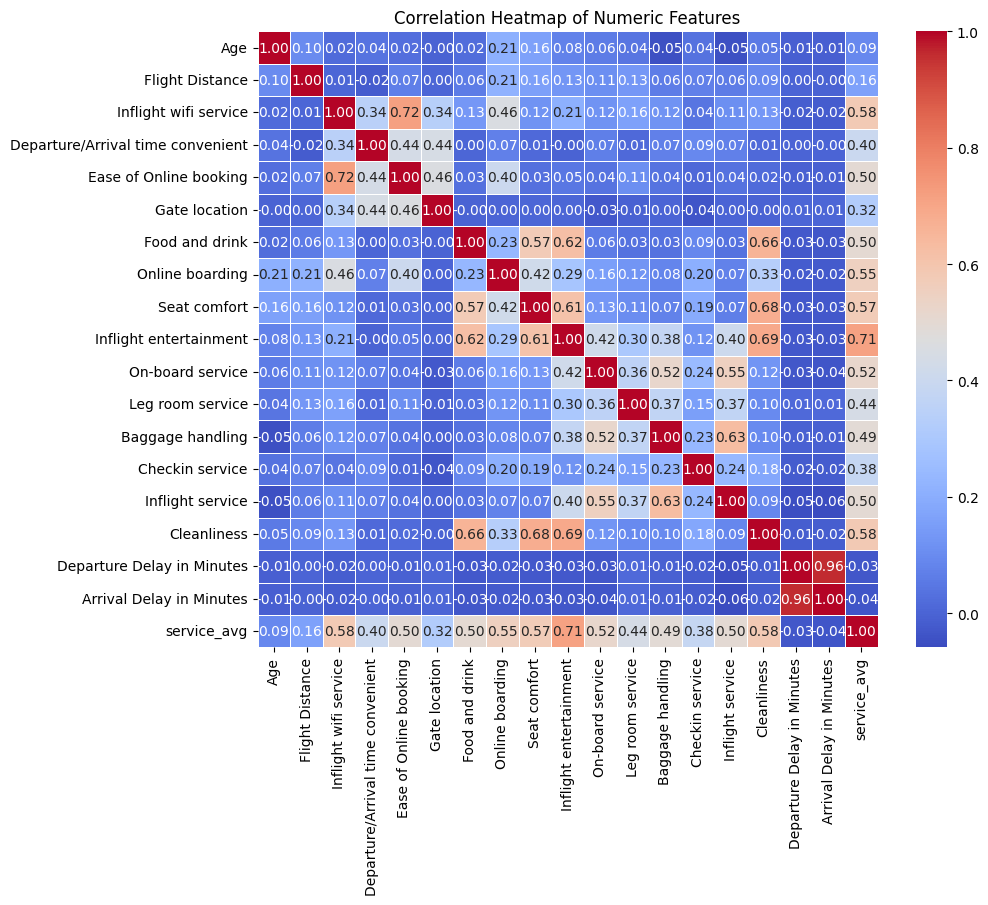

In [103]:
corr_matrix = numeric_data.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

**Boxplot of service Vs Satisfaction level**

<ipython-input-104-9f00b0391231>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='satisfaction_level', y=col, data=Airline_train_data, palette='Set2')
<ipython-input-104-9f00b0391231>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='satisfaction_level', y=col, data=Airline_train_data, palette='Set2')
<ipython-input-104-9f00b0391231>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='satisfaction_level', y=col, data=Airline_train_data, palette='Set2')
<ipython-input-104-9f00b0391231>:7: FutureWarning: 

Passing `palette` without assign

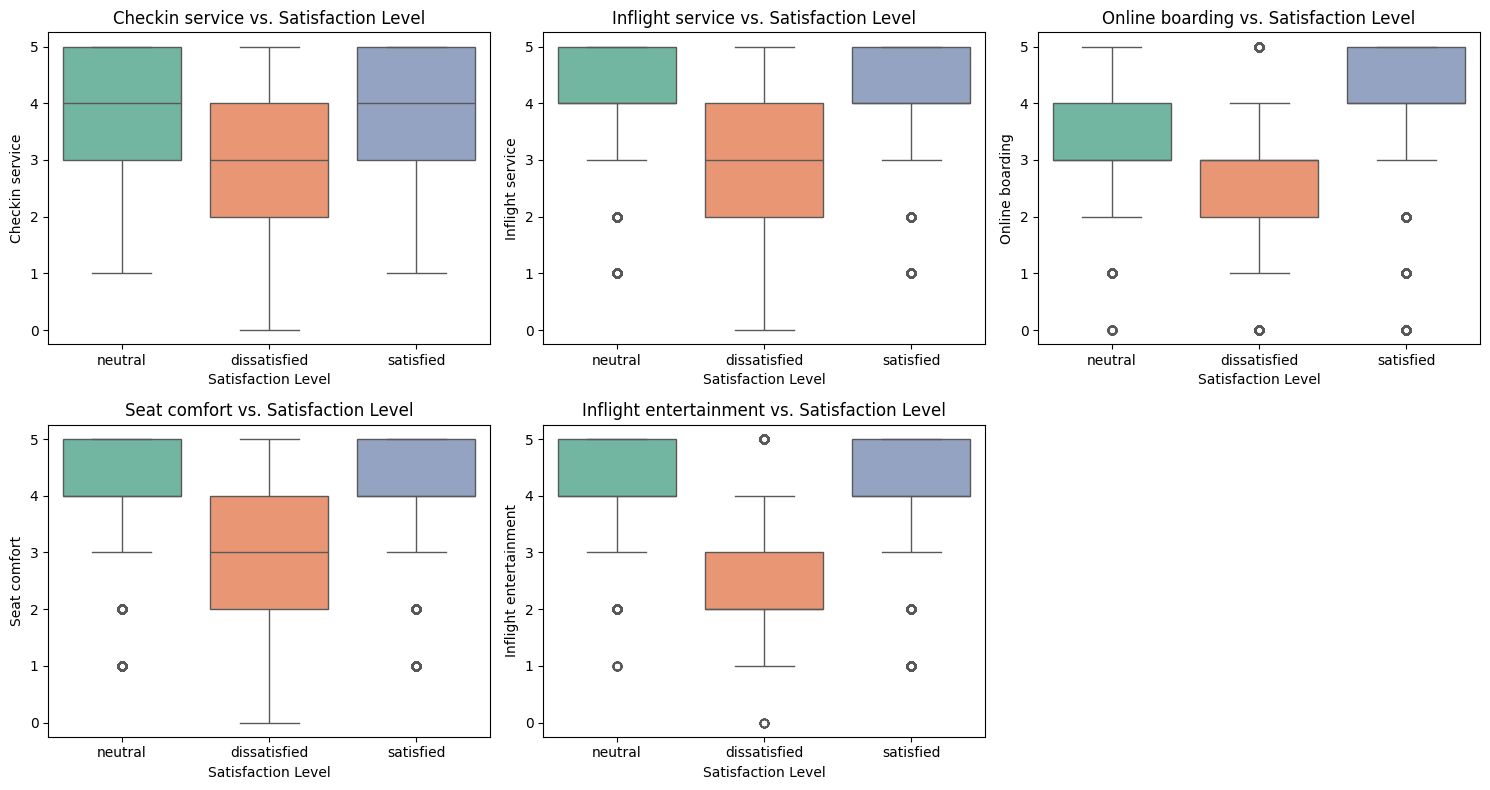

In [104]:
service_cols = ['Checkin service', 'Inflight service', 'Online boarding', 'Seat comfort', 'Inflight entertainment']

# Create subplots for each boxplot
plt.figure(figsize=(15, 8))
for i, col in enumerate(service_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x='satisfaction_level', y=col, data=Airline_train_data, palette='Set2')
    plt.title(f'{col} vs. Satisfaction Level')
    plt.xlabel('Satisfaction Level')
    plt.ylabel(col)

plt.tight_layout()
plt.show()

**Sactterplot of Delays by Satisfaction level**

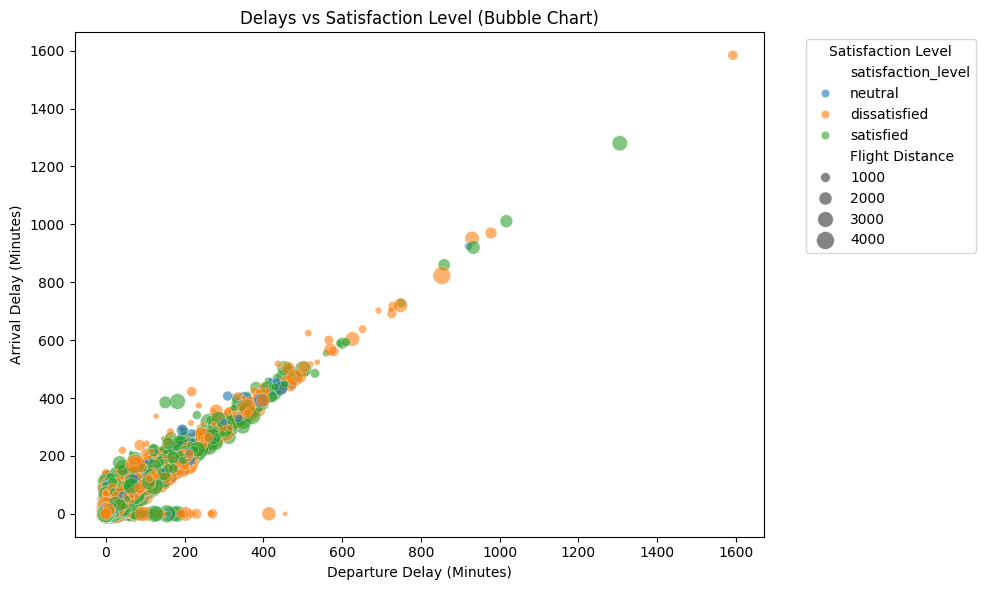

In [105]:
#Scatterplot(Bubble Chart) Delays vs Satisfaction level
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=Airline_train_data,
    x="Departure Delay in Minutes",
    y="Arrival Delay in Minutes",
    hue="satisfaction_level",
    size="Flight Distance",
    sizes=(10, 200),
    alpha=0.6
)

plt.title("Delays vs Satisfaction Level (Bubble Chart)")
plt.xlabel("Departure Delay (Minutes)")
plt.ylabel("Arrival Delay (Minutes)")
plt.legend(title="Satisfaction Level", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Histogram of Distribution of Flight Distance by Satisfaction**

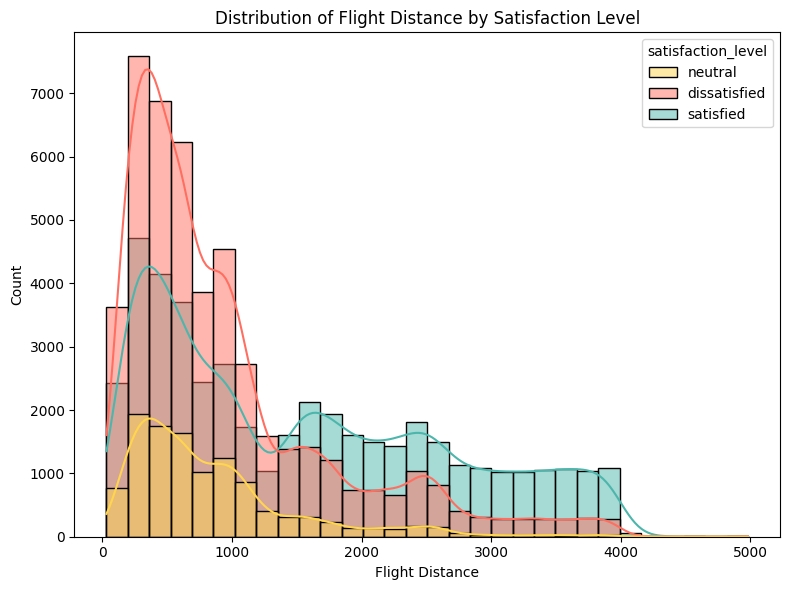

In [106]:
#Histogram of Distribution of Flight Distance by Satisfaction
plt.figure(figsize=(8, 6))
sns.histplot(
    data=Airline_train_data,
    x="Flight Distance",
    hue="satisfaction_level",
    bins=30,
    palette={
        'dissatisfied': '#FF6F61',
        'neutral': '#FFD54F',
        'satisfied': '#4DB6AC'
    },
    kde=True
)

plt.title("Distribution of Flight Distance by Satisfaction Level")
plt.xlabel("Flight Distance")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

**lineplot of Average check-in Service rating by class**

<ipython-input-107-0d2dcb4a12c4>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_checkin_by_class = Airline_train_data.groupby("Class")["Checkin service"].mean().reset_index()


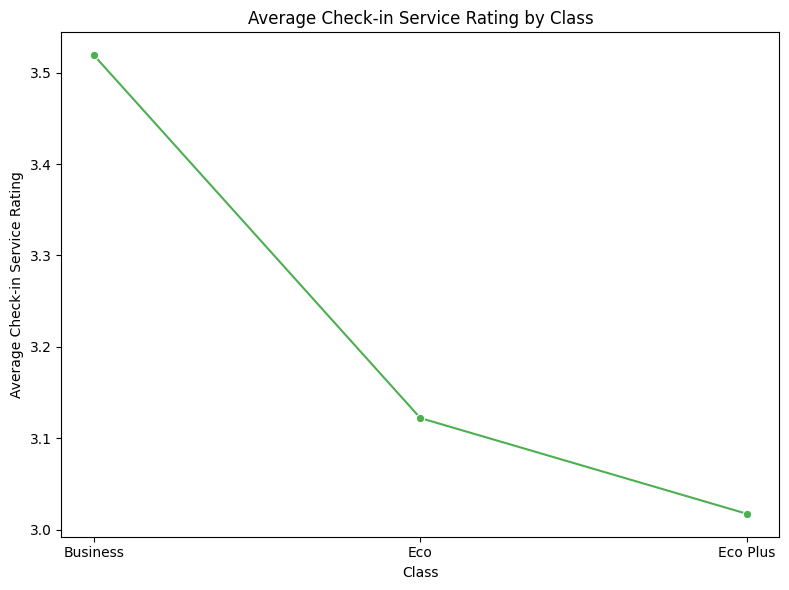

In [107]:
# Calculate the average check-in service rating per Class
avg_checkin_by_class = Airline_train_data.groupby("Class")["Checkin service"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 6))
sns.lineplot(data=avg_checkin_by_class, x="Class", y="Checkin service",
             marker="o", color="#4CAF50")
plt.title("Average Check-in Service Rating by Class")
plt.xlabel("Class")
plt.ylabel("Average Check-in Service Rating")
plt.tight_layout()
plt.show()


**Pie Chart of Average service Ratings**

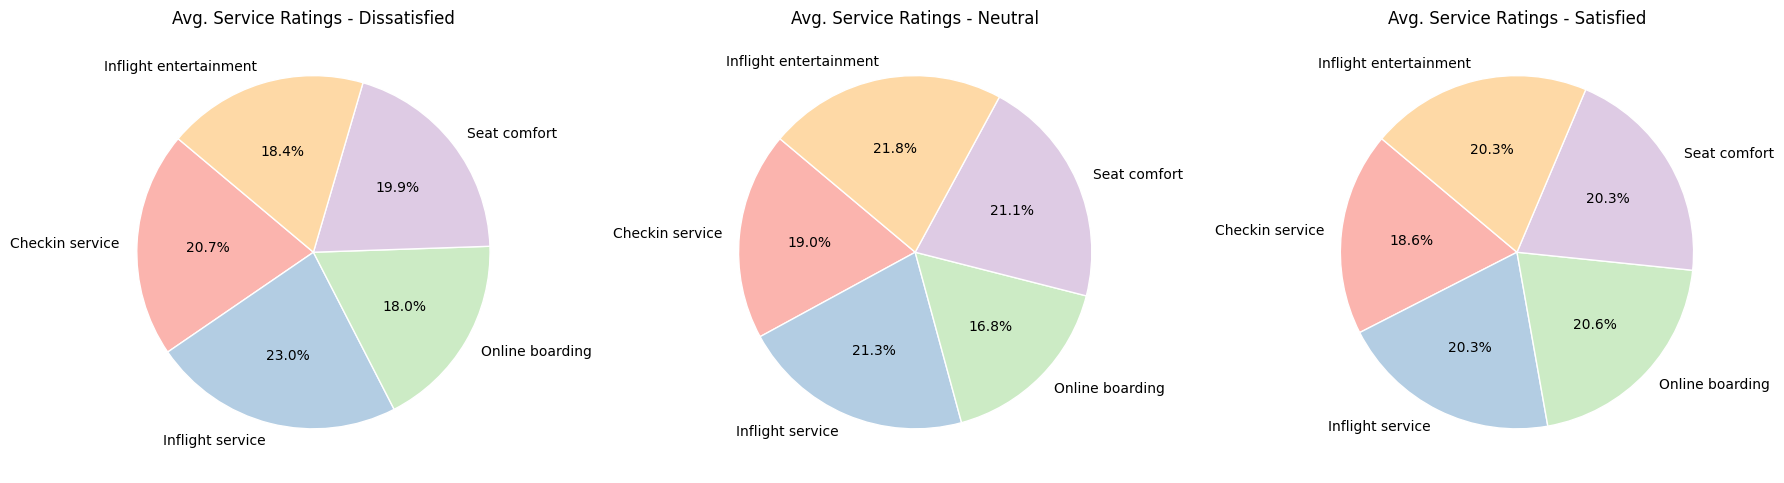

In [108]:
# Define the service columns
service_columns = ['Checkin service', 'Inflight service', 'Online boarding',
                   'Seat comfort', 'Inflight entertainment']

# Group data by satisfaction_level and calculate mean ratings
grouped = Airline_train_data.groupby('satisfaction_level')[service_columns].mean()

# Define calm colors for pie titles
labels = ['Dissatisfied', 'Neutral', 'Satisfied']

# Plot 3 pie charts (one per satisfaction level)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, satisfaction_value in enumerate(grouped.index):
    axes[i].pie(
        grouped.loc[satisfaction_value],
        labels=service_columns,
        autopct='%1.1f%%',
        colors=plt.cm.Pastel1.colors,  # Calmer pastel colors
        startangle=140,
        wedgeprops={'edgecolor': 'white'}
    )
    axes[i].set_title(f"Avg. Service Ratings - {labels[i]}")

plt.tight_layout()
plt.show()


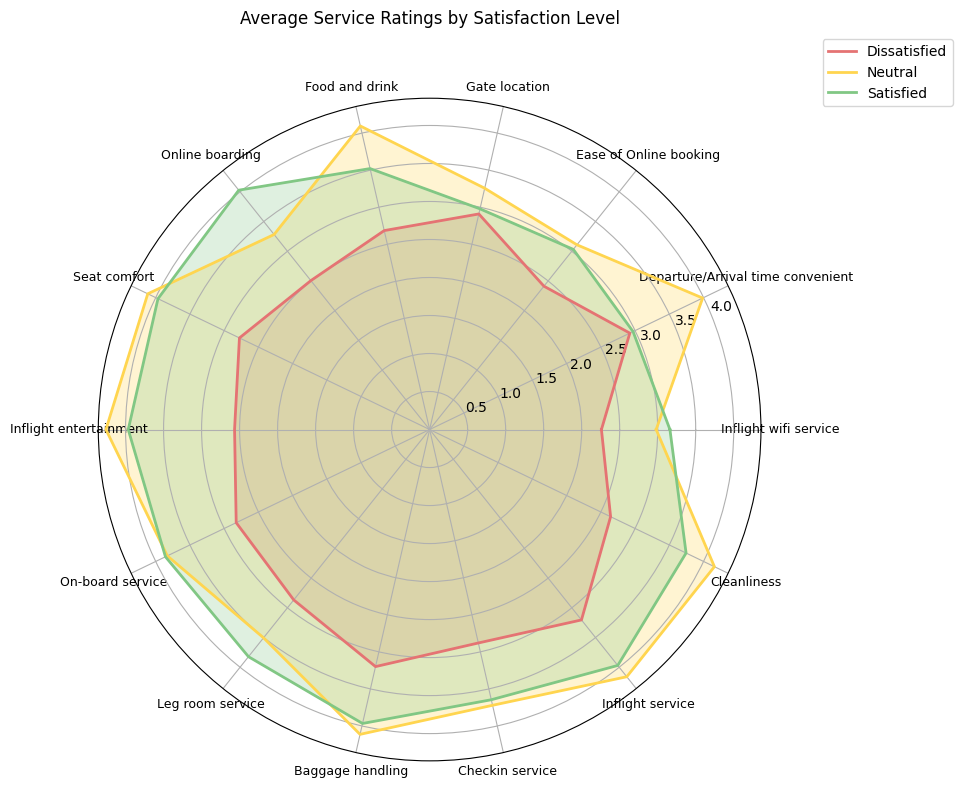

In [109]:
# List of service-related columns
service_columns = [
    'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
    'Inflight entertainment', 'On-board service', 'Leg room service',
    'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness'
]

# Group the data by satisfaction_level and calculate average ratings
grouped = Airline_train_data.groupby('satisfaction_level')[service_columns].mean()

# Prepare radar chart details
categories = service_columns
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Repeat first angle to close the circle

# Initialize radar plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Define colors and labels for satisfaction levels
colors = {
    'dissatisfied': '#E57373',   # soft red
    'neutral': '#FFD54F',        # soft yellow
    'satisfied': '#81C784'       # soft green
}

# Plot each satisfaction group
for level in grouped.index:
    values = grouped.loc[level].tolist()
    values += values[:1]  # repeat the first value
    ax.plot(angles, values, color=colors[level], linewidth=2, label=level.capitalize())
    ax.fill(angles, values, color=colors[level], alpha=0.25)

# Set labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=9, rotation=45)
ax.set_title("Average Service Ratings by Satisfaction Level", y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


# **Model building**

In [110]:
#Define Features and Target
X = Airline_train_data.drop(columns=["satisfaction", "satisfaction_level", "service_avg"])  # Drop irrelevant columns
y = Airline_train_data["satisfaction_level"]


In [111]:
#Train-test Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [112]:
#Label Encode categorical Features
label_encoder = LabelEncoder()
categorical_cols = x_train.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    x_train[col] = label_encoder.fit_transform(x_train[col].astype(str))
    x_test[col] = label_encoder.transform(x_test[col].astype(str))


In [113]:
#Train Random Foret classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)
rf_probs = rf_model.predict_proba(x_test)
rf_preds = rf_model.predict(x_test)


In [114]:
#Evaluate Random Forest Classifier Model with Accuracy and Classifiation Report
from sklearn.metrics import accuracy_score, classification_report
print("🔹 Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, rf_preds))



🔹 Random Forest Accuracy: 0.9377797026129637

Random Forest Classification Report:
               precision    recall  f1-score   support

dissatisfied       0.93      0.97      0.95      9426
     neutral       0.86      0.78      0.81      2287
   satisfied       0.96      0.94      0.95      9068

    accuracy                           0.94     20781
   macro avg       0.92      0.90      0.91     20781
weighted avg       0.94      0.94      0.94     20781



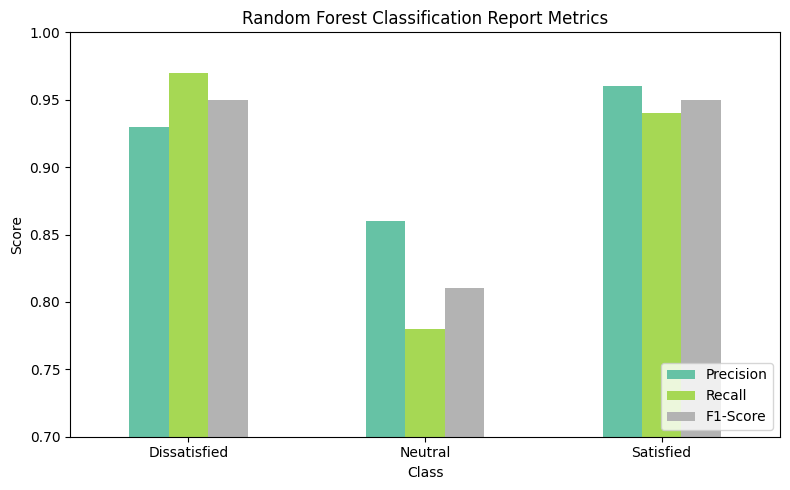

In [115]:

# Create a DataFrame for the metrics
metrics_data = {
    'Class': ['Dissatisfied', 'Neutral', 'Satisfied'],
    'Precision': [0.93, 0.86, 0.96],
    'Recall':    [0.97, 0.78, 0.94],
    'F1-Score':  [0.95, 0.81, 0.95]
}

metrics_df = pd.DataFrame(metrics_data).set_index('Class')

# Plot
metrics_df.plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title("Random Forest Classification Report Metrics")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


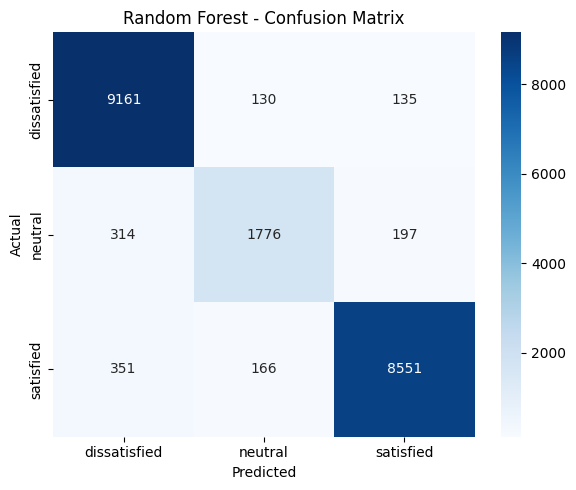

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, rf_preds, labels=['dissatisfied', 'neutral', 'satisfied'])

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['dissatisfied', 'neutral', 'satisfied'],
            yticklabels=['dissatisfied', 'neutral', 'satisfied'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Confusion Matrix")
plt.tight_layout()
plt.show()


In [117]:
#Train LightGBM Classifier
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(x_train, y_train)
lgbm_probs = lgbm_model.predict_proba(x_test)
lgbm_preds = lgbm_model.predict(x_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 938
[LightGBM] [Info] Number of data points in the train set: 83123, number of used features: 23
[LightGBM] [Info] Start training from score -0.781552
[LightGBM] [Info] Start training from score -2.209742
[LightGBM] [Info] Start training from score -0.837998


In [118]:
#Evaluate LightBGM Model with Accuracy and Classifiation Report

print("🔹 LightGBM Accuracy:", accuracy_score(y_test, lgbm_preds))
print("\nLightGBM Classification Report:\n", classification_report(y_test, lgbm_preds))

🔹 LightGBM Accuracy: 0.9508685818776768

LightGBM Classification Report:
               precision    recall  f1-score   support

dissatisfied       0.95      0.98      0.97      9426
     neutral       0.89      0.87      0.88      2287
   satisfied       0.96      0.94      0.95      9068

    accuracy                           0.95     20781
   macro avg       0.93      0.93      0.93     20781
weighted avg       0.95      0.95      0.95     20781



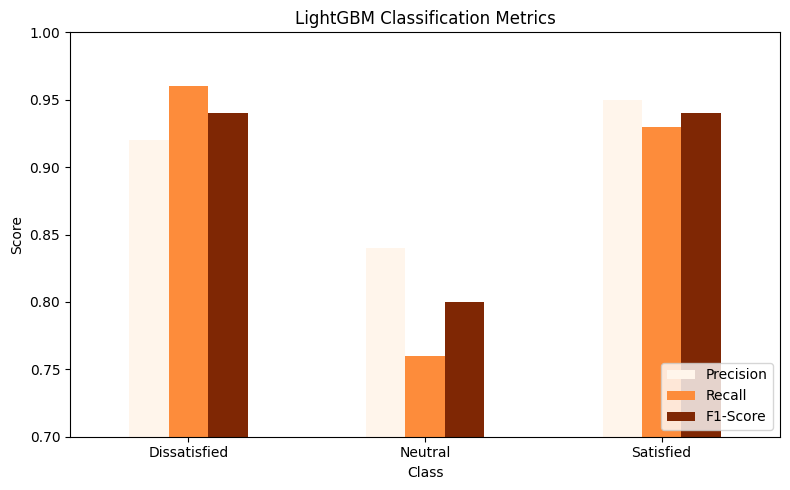

In [119]:
lgbm_metrics = {
    'Class': ['Dissatisfied', 'Neutral', 'Satisfied'],
    'Precision': [0.92, 0.84, 0.95],
    'Recall':    [0.96, 0.76, 0.93],
    'F1-Score':  [0.94, 0.80, 0.94]
}
lgbm_df = pd.DataFrame(lgbm_metrics).set_index('Class')

# --- LightGBM Plot ---
lgbm_df.plot(kind='bar', figsize=(8, 5), colormap='Oranges')
plt.title("LightGBM Classification Metrics")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

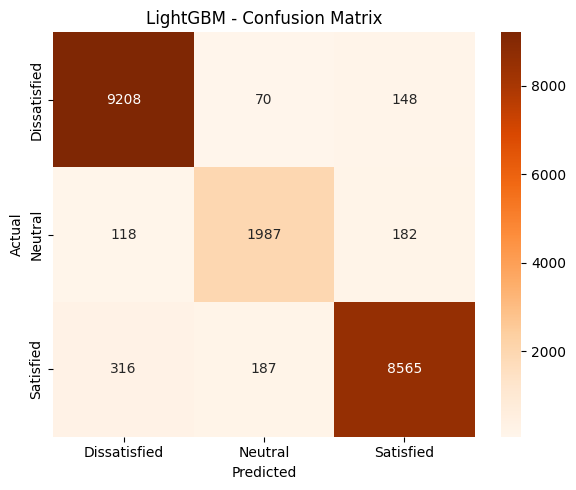

In [120]:
# Generate the confusion matrix
cm_lgbm = confusion_matrix(y_test, lgbm_preds, labels=['dissatisfied', 'neutral', 'satisfied'])

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Dissatisfied', 'Neutral', 'Satisfied'],
            yticklabels=['Dissatisfied', 'Neutral', 'Satisfied'])

plt.title("LightGBM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## ***Model Comparison and Final Selection ***

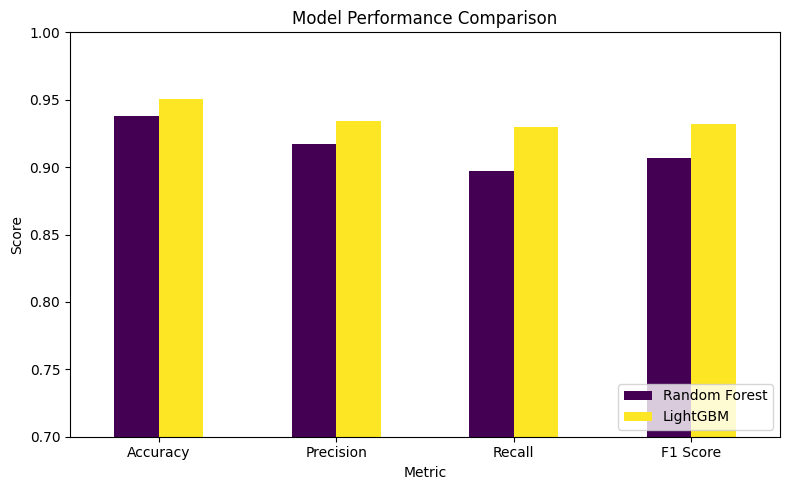

In [121]:
#ploting of Accuracy, Precision, Recall, F1 score for Random Forest and LightGBM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
rf_accuracy = accuracy_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds, average='macro')
rf_recall = recall_score(y_test, rf_preds, average='macro')
rf_f1 = f1_score(y_test, rf_preds, average='macro')

lgbm_accuracy = accuracy_score(y_test, lgbm_preds)
lgbm_precision = precision_score(y_test, lgbm_preds, average='macro')
lgbm_recall = recall_score(y_test, lgbm_preds, average='macro')
lgbm_f1 = f1_score(y_test, lgbm_preds, average='macro')

# Create DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Random Forest': [rf_accuracy, rf_precision, rf_recall, rf_f1],
    'LightGBM': [lgbm_accuracy, lgbm_precision, lgbm_recall, lgbm_f1]
}).set_index('Metric')

# Plot
metrics_df.plot(kind='bar', figsize=(8, 5), colormap='viridis')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


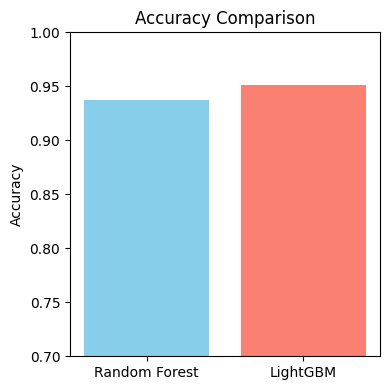

In [122]:
#Accuracy comparison

plt.figure(figsize=(4, 4))
plt.bar(['Random Forest', 'LightGBM'], [rf_accuracy, lgbm_accuracy], color=['skyblue', 'salmon'])
plt.title("Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()


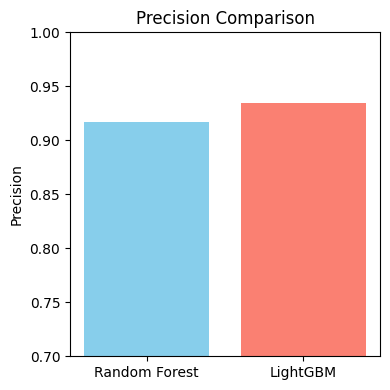

In [123]:
#Precision Comparison
plt.figure(figsize=(4, 4))
plt.bar(['Random Forest', 'LightGBM'], [rf_precision, lgbm_precision], color=['skyblue', 'salmon'])
plt.title("Precision Comparison")
plt.ylabel("Precision")
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()


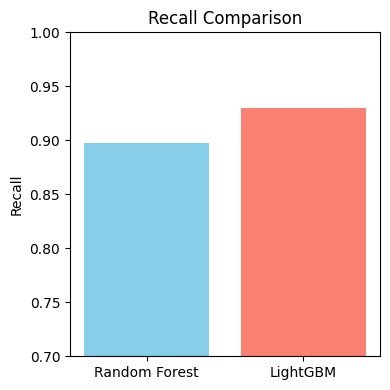

In [124]:
#Recall Comparison
plt.figure(figsize=(4, 4))
plt.bar(['Random Forest', 'LightGBM'], [rf_recall, lgbm_recall], color=['skyblue', 'salmon'])
plt.title("Recall Comparison")
plt.ylabel("Recall")
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()


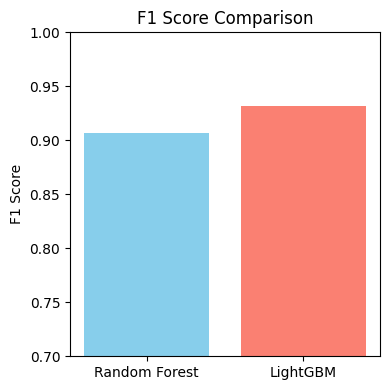

In [125]:
#F1 Score Comparision
plt.figure(figsize=(4, 4))
plt.bar(['Random Forest', 'LightGBM'], [rf_f1, lgbm_f1], color=['skyblue', 'salmon'])
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

In [126]:
#calculate ROC-AUC Scores
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

classes = ['dissatisfied', 'neutral', 'satisfied']
y_test_bin = label_binarize(y_test, classes=classes)

rf_auc = roc_auc_score(y_test_bin, rf_probs, multi_class='ovr')
lgbm_auc = roc_auc_score(y_test_bin, lgbm_probs, multi_class='ovr')

print(" Random Forest ROC-AUC:", rf_auc)
print(" LightGBM ROC-AUC:", lgbm_auc)


 Random Forest ROC-AUC: 0.9911570947349219
 LightGBM ROC-AUC: 0.9946798456940051


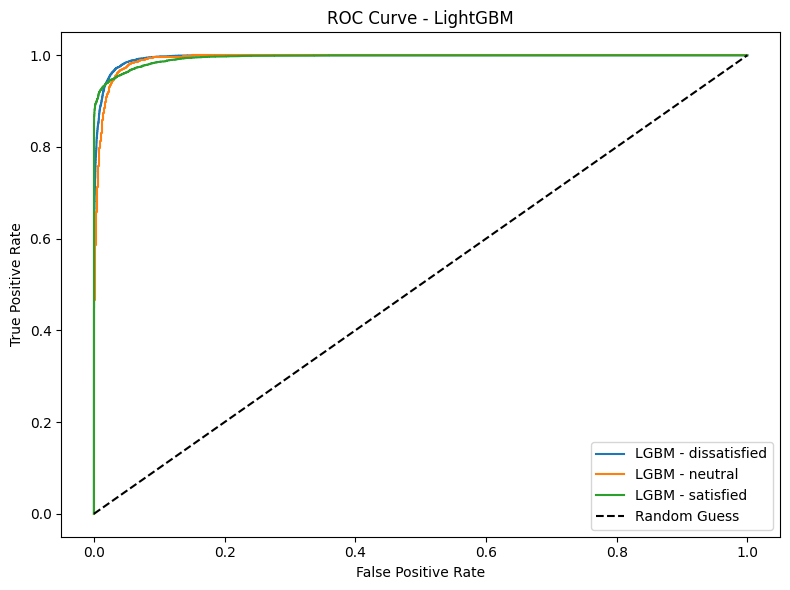

In [127]:
#Plot ROC curve for LightBGM Model
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test_bin[:, i], lgbm_probs[:, i])
    plt.plot(fpr_lgbm, tpr_lgbm, linestyle='-', label=f'LGBM - {class_label}')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("ROC Curve - LightGBM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()


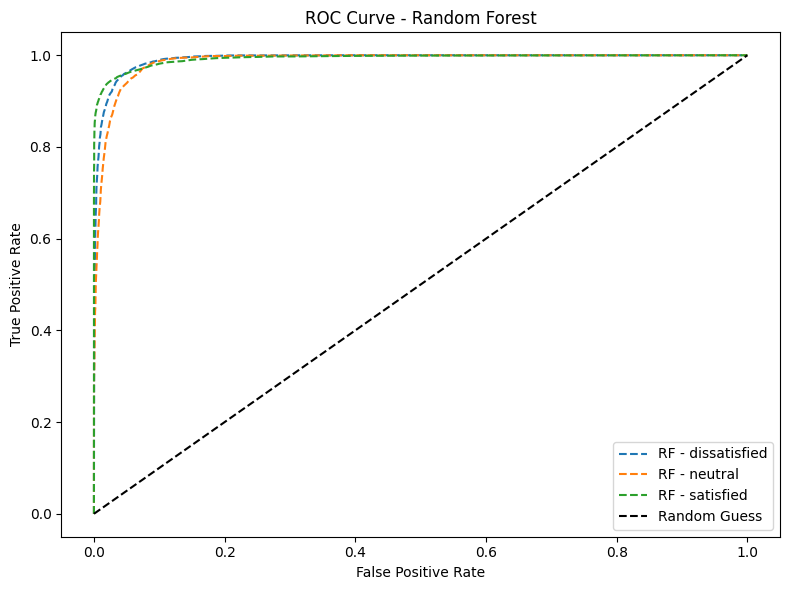

In [128]:
#Plot ROC Curves for Random Forest Model
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(classes):
    fpr_rf, tpr_rf, _ = roc_curve(y_test_bin[:, i], rf_probs[:, i])
    plt.plot(fpr_rf, tpr_rf, linestyle='--', label=f'RF - {class_label}')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()

